# AMES House Price Prediction

Find extensive Data Exploration in this NOtebook with each and every step in detail analysis.

Hope you find this notebook useful : )

# Data Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings  
warnings.filterwarnings('ignore')

**Load the train and the test data and have a quick look at our dataset**

In [2]:
path = '/kaggle/input/house-prices-advanced-regression-techniques/'

df_train = pd.read_csv(path + "train.csv")
df_test = pd.read_csv(path + "test.csv")
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Target Feature Analysis

We will plot **Histogram** and **QQPlot** to analyze the distribution and skewness type of the target feature.

Skewness Co-efficient: 1.883


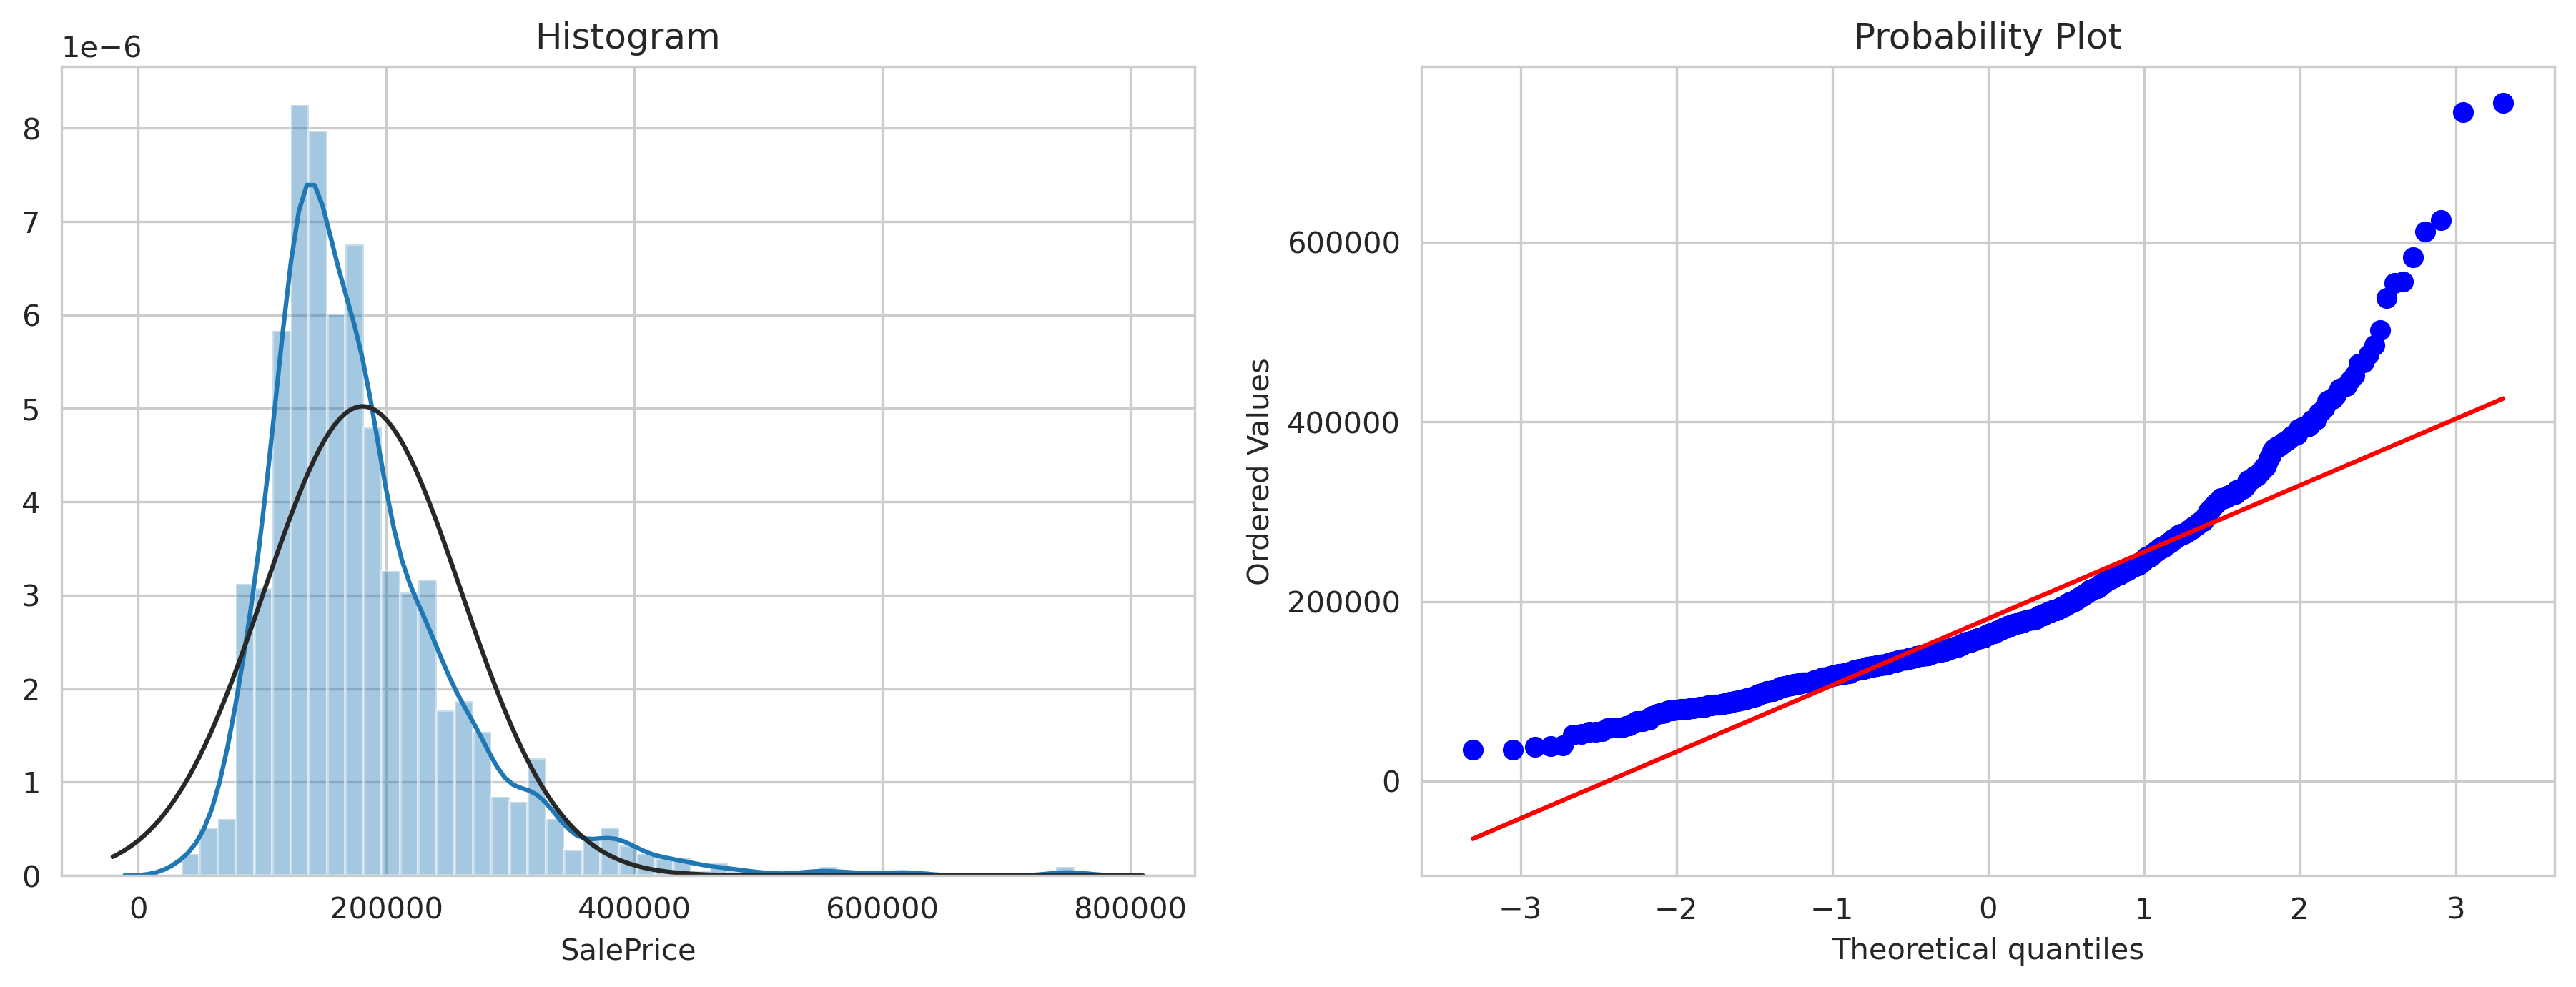

In [3]:
##### GET SKEWNESS #####
print(f"Skewness Co-efficient: {round(df_train.SalePrice.skew(), 3)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

##### HISTOGRAM #####
from scipy import stats
sns.distplot(df_train['SalePrice'] , fit=stats.norm, ax=ax1)
ax1.set_title('Histogram')

##### PROBABILITY / QQ PLOT #####
stats.probplot(df_train['SalePrice'], plot=ax2)

plt.show()

**Analysis:**

* The Skewness co-efficient suggested the target feature is positive skewed.
* We will apply log transformation to the feature to make the distribution close to gaussian.
* We will apply `log(1+x)` transformation to avoid `0` values (if present).
* After transforming the variable, we will see both the above plots again.

Skewness Co-efficient: 0.121


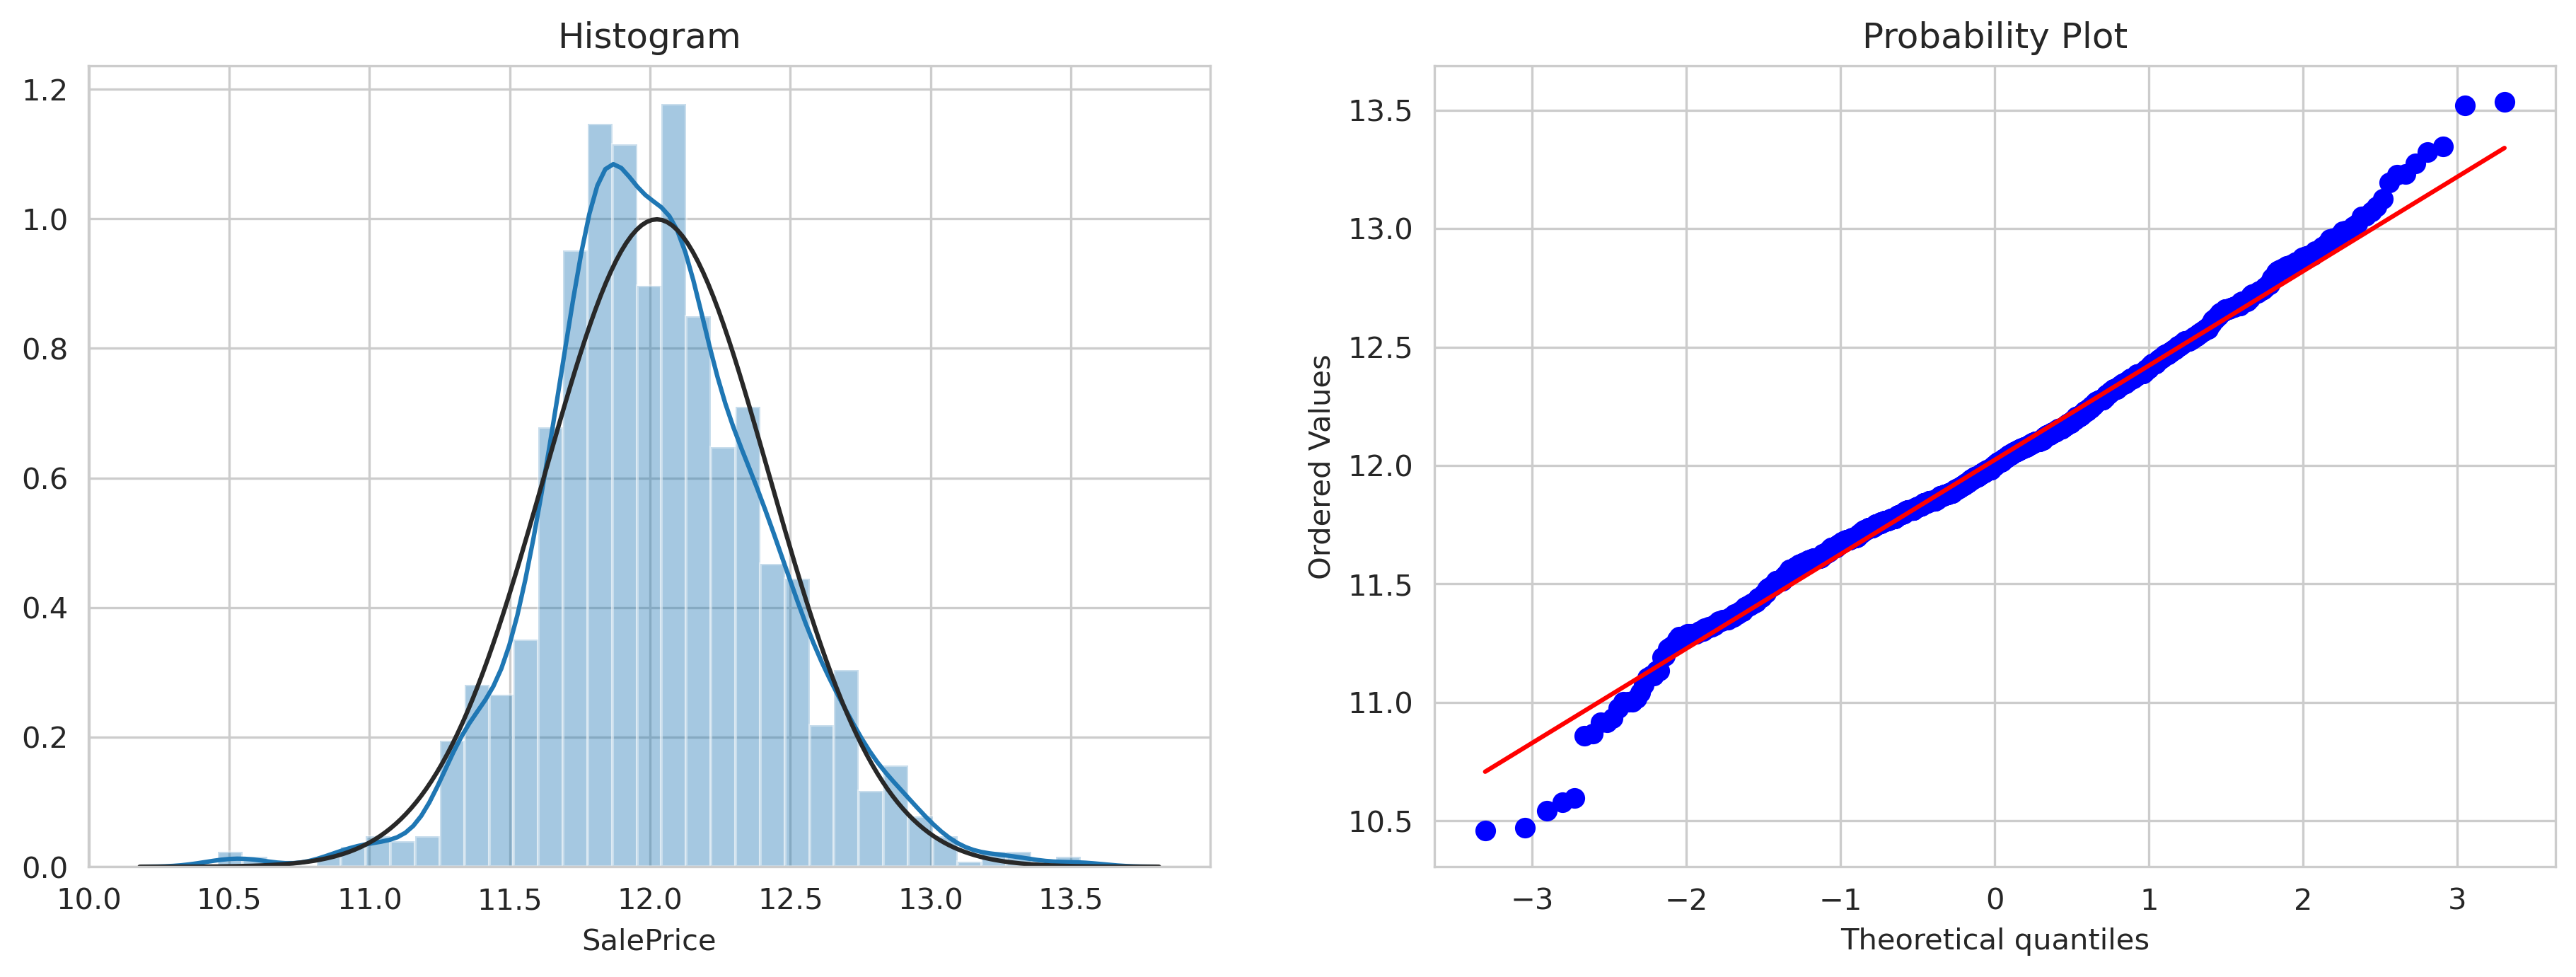

In [4]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

##### GET SKEWNESS #####
print(f"Skewness Co-efficient: {round(df_train.SalePrice.skew(), 3)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

##### HISTOGRAM #####
from scipy import stats
sns.distplot(df_train['SalePrice'] , fit=stats.norm, ax=ax1)
ax1.set_title('Histogram')

##### PROBABILITY / QQ PLOT #####
stats.probplot(df_train['SalePrice'], plot=ax2)

plt.show()

**After-Transformation Analysis:**
* The skewness has reduced (from `1.883` to `0.121`) and the plot now looks close to the normal distribution.
* Even the probability plot can confirm the same.

**We will be concatenating our `train` and `test` dataframes for two purpose**
1. To avoid repeating all the operations (such as transformations, imputations, etc) done on the train set for the test set.
2. To get more data for our analysis (`More the data, the BETTER it is.!!`)

In [5]:
'''
    Store the number of rows or indexes for train and test dataset
    to separate them while performing modeling and prediction.
'''
ntrain = df_train.shape[0]
ntest = df_test.shape[0]

all_data = pd.concat((df_train, df_test)).reset_index(drop=True)

nindex, nfeatures = all_data.shape

# Data Preparation

## Missing Value Imputation

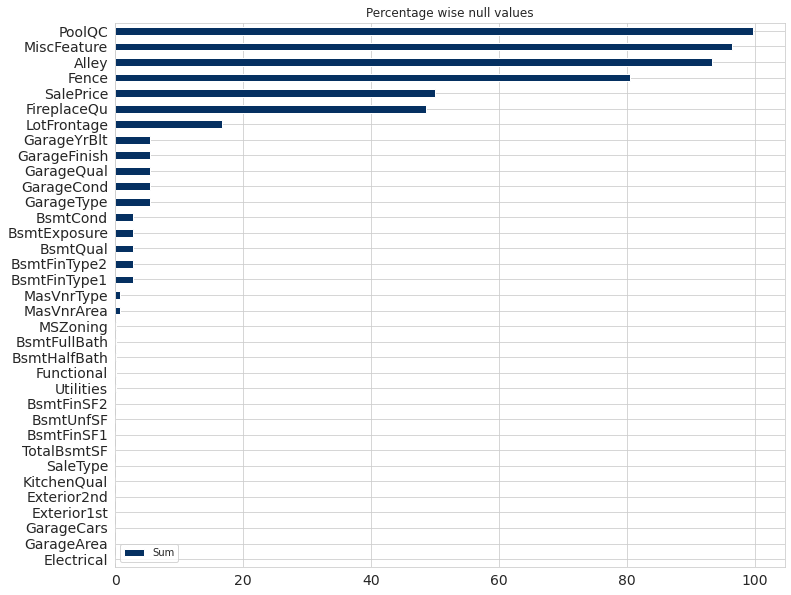

In [6]:
## Get the dataframe with all the features and SUM of the NaN values present
df_null_count = all_data.isnull().sum().to_frame().rename({0:"Sum"}, axis=1)

## Select only those features who have atleast 1 NaN value
df_null_count = df_null_count[df_null_count['Sum'] > 0]

## Change the SUM to PERCENTAGE 
df_null_count['Sum'] = df_null_count['Sum']*(100/nindex)

## Plot a Horizontal Bar Graph
df_null_count.sort_values(by="Sum", ascending=True).plot(
    kind='barh', figsize=(12,10), fontsize=14, colormap="RdBu_r", title="Percentage wise null values"
)
plt.show()

**Analysis:**
* `PoolQC`, `MiscFeature`, and `Alley` have more than 50% values as `NaN`. Our first impression will be to drop them but instead in our analysis we will take these features and leave it to our `feature selection` algorithm to provide important set of features.
* We will perform Missing Value Imputation for each and every feature mentioned in the bar graph. 
* `SalePrice` will be ignored since the missing  values belong to the test set. Out train set does not contain any missing values. We can confirm the same by the following code.

```code
>>> df.SalePrice.isnull().sum()
... 0
```

### PoolQC :: Pool quality

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

_Unique Values in PoolQC_

```code
>>> all_data.PoolQC.unique()
... [nan, 'Ex', 'Fa', 'Gd']
```

`NaN` must be a blank field in the data corresponding to `NA` i.e. *No Pool*

Replacing `NaN` with a string value `None`

Also, the values can be represented in an order ie ORDINAL Variable.

In [7]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

quality_map = {
    "None": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4
}

all_data['PoolQC'].replace(quality_map, inplace=True)

### MiscFeature :: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	  None

_Unique Values in MiscFeature_

```code
>>> all_data.MiscFeature.unique()
... [nan, 'Shed', 'Gar2', 'Othr', 'TenC']
```
`NaN` must be a blank field in the data corresponding to no miscellaneous feature.

Replacing `NaN` with a string value `None`

In [8]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

### Alley :: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
       
_Unique Values in Alley_
```code
>>> all_data.Alley.unique()
... [nan, 'Grvl', 'Pave']
```

`NaN` must be a blank field in the data corresponding to no alley access.

Replacing `NaN` with a strig value `None`

In [9]:
all_data['Alley'] = all_data['Alley'].fillna('None')

### Fence :: Fence Quality

       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
       
_Unique Values in Fence_
```code
>>> all_data.Fence.unique()
... [nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw']
```

`NaN` must be a blank field in the data corresponding to no fence.

Replacing `NaN` with a strig value `None`

In [10]:
all_data['Fence'] = all_data['Fence'].fillna('None')

### FireplaceQu :: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
       
_Unique Values in FireplaceQu_
```code
>>> all_data.FireplaceQu.unique()
... [nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po']
```

`NaN` must be a blank field in the data corresponding to no fireplace.

Replacing `NaN` with a strig value `None`

In [11]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

quality_map = {
    "None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5
}

all_data['FireplaceQu'].replace(quality_map, inplace=True)

### LotFrontage :: Linear feet of street connected to property

```code
>>> all_data['LotFrontage'].dtype
... dtype('float64')
```

Since it is a numeric feature, let us try to impute mean or median values by refering to the distribution of the feature values.

Skewness value: 1.50


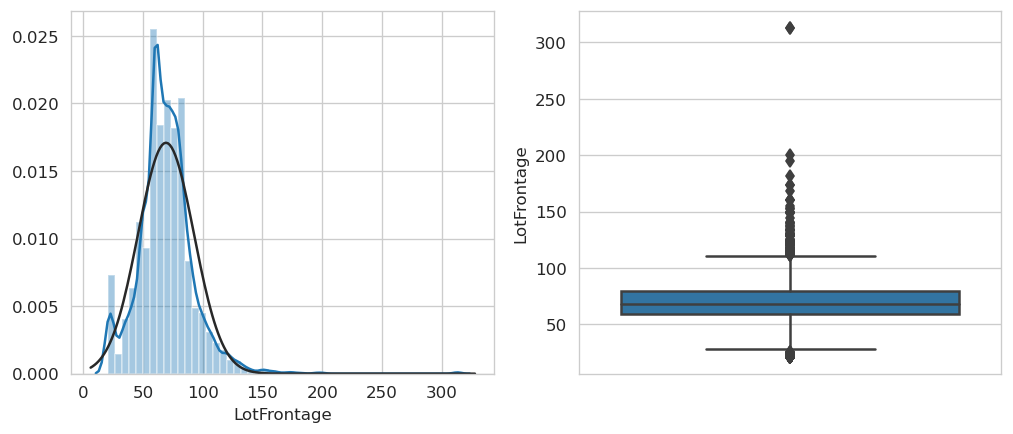

In [12]:
from scipy.stats import norm, skew

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

sns.distplot(all_data['LotFrontage'].dropna(), fit=norm, ax=ax1)
sns.boxplot(all_data['LotFrontage'].dropna(), ax=ax2, orient='v')

print(f"Skewness value: %.2f" %all_data['LotFrontage'].dropna().skew())

#### The skewness value of `2.16` and the boxplot denote that the distribution is highly positive skewed with high number of outliers (extreme values). 

#### Therefore, we will make use of`median` imputation instead of `mean` imputation to avoid extreme values to have an impact.

In [13]:
all_data['LotFrontage'].fillna(value=all_data['LotFrontage'].median(), inplace=True)

### Analysis of Garage Feature

There are a total of 5 Garage Features having null values in them -

*GarageType: Garage location*
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
*GarageYrBlt: Year garage was built*
		
*GarageFinish: Interior finish of the garage*

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

*GarageQual: Garage quality*

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
*GarageCond: Garage condition*

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
       
*GarageCars: Size of garage in car capacity*

*GarageArea: Size of garage in square feet*

---
       
```code
>>> all_data['GarageType'].unique()
... ['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types']
```
The above code shows the unique values present the GarageType feature. Our assumption is that `NaN` values correspond to houses with no garages.
       
Let us create a Garage Dataframe to further analyse the null values present.

In [14]:
df_no_garage = all_data[[
    'GarageYrBlt', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageCars', 'GarageArea'
]][
    all_data['GarageType'].isnull()
]

df_no_garage.head(5)

,GarageYrBlt,GarageCond,GarageFinish,GarageQual,GarageType,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0
48,NaN,NaN,NaN,NaN,NaN,0.0,0.0
78,NaN,NaN,NaN,NaN,NaN,0.0,0.0
88,NaN,NaN,NaN,NaN,NaN,0.0,0.0
89,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In the above dataframe we can notice that when the feature `GarageTpe` is `NaN`, the corresponding categorical Garage features are also `NaN` and the numerical features are `0`. This clearly indicates absence of garage for the house.

In [15]:
print(f"Total number of entries with Null Garage Type are {len(df_no_garage.index)}.")

Total number of entries with Null Garage Type are 157.


**Here we can safely impute the `NaN` values with string value of `None` for all the above features.**

**NOTE**: The additional two features GarageCars and GarageArea have a value of `0` for the corresponding `NaN` values.

In [16]:
for feature in ['GarageCond', 'GarageFinish', 'GarageQual', 'GarageType']:
    all_data[feature].fillna(value='None', inplace=True)
    
for feature in ['GarageYrBlt', 'GarageCars', 'GarageArea']:
    all_data[feature].fillna(value=0, inplace=True)

#### Further analysis of Garage Features

* `GarageFinish`, `GarageQual` and `GarageCond` can be converted to ordinal variables.

In [17]:
#all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(str)

quality_map = {
    "None": 0, "Po": 1,"Fa": 2, "TA": 3, "Gd": 4, "Ex": 5
}

all_data['GarageQual'].replace(quality_map, inplace=True)
all_data['GarageCond'].replace(quality_map, inplace=True)

quality_map = {
    "None": 0, "Unf": 1, "RFn": 2, "Fin": 3
}

all_data['GarageFinish'].replace(quality_map, inplace=True)

--- 
#### We could see a similar kind of pattern being followed by the next 5 basement features. Let us analyse these features using a similar approach.

### Analysis of Basement Features

There are a total of 5 Garage Features having null values in them -

*BsmtQual: Evaluates the height of the basement*

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
*BsmtCond: Evaluates the general condition of the basement*

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
*BsmtExposure: Refers to walkout or garden level walls*

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
*BsmtFinType1: Rating of basement finished area*

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

*BsmtFinType2: Rating of basement finished area (if multiple types)*

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
 
*BsmtFullBath: Basement full bathrooms*

*BsmtHalfBath: Basement half bathrooms*

*BsmtFinSF1: Type 1 finished square feet*

*BsmtFinSF2: Type 2 finished square feet*

*BsmtUnfSF: Unfinished square feet of basement area*

*TotalBsmtSF: Total square feet of basement area*

---
       
```code
>>> all_data['BsmtQual'].unique()
... ['Gd', 'TA', 'Ex', nan, 'Fa']
```
The above code shows the unique values present the BsmtQual feature. Our assumption is that `NaN` values correspond to houses with no basement.
       
Let us create a Basement Dataframe to further analyse the null values present.

In [18]:
no_basement_df = all_data[[
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtFinSF1', 
    'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF'
]][
    all_data['BsmtQual'].isnull()
]

no_basement_df.head(5)

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
90,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
102,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
156,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
print(f"Total number of entries with Null Basement Cond are {len(no_basement_df.index)}.")

Total number of entries with Null Basement Cond are 81.


#### Safely imputing `NaN` value with string value of `None` for all the categorical features and `0` for numeric variables.

In [20]:
for feature in ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']:
    all_data[feature].fillna(value='None', inplace=True)
    
for feature in ['BsmtFinSF1', 'BsmtFinSF2','BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF']:
    all_data[feature].fillna(value=0, inplace=True)

#### Further Analysis of Basement Feature

* All the basement features can be converted in to `ordinal` variables. (Label Encoding)

In [21]:
''' BsmtCond and BsmtQual '''

quality_map = {
    "None": 0, "Po": 1,"Fa": 2, "TA": 3, "Gd": 4, "Ex": 5
}

all_data['BsmtCond'].replace(quality_map, inplace=True)
all_data['BsmtQual'].replace(quality_map, inplace=True)

''' BsmtExposure '''

quality_map = {
    "None": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4
}

all_data['BsmtExposure'].replace(quality_map, inplace=True)

''' BsmtFinType1 and BsmtFinType2 '''

quality_map = {
    "None": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6
}

all_data['BsmtFinType1'].replace(quality_map, inplace=True)
all_data['BsmtFinType2'].replace(quality_map, inplace=True)

### Analysis of Masonry Veneer Type and Area

*MasVnrType: Masonry veneer type*

       BrkCmn	 Brick Common
       BrkFace	Brick Face
       CBlock	 Cinder Block
       None	   None
       Stone	  Stone
	
*MasVnrArea: Masonry veneer area in square feet*

```code
>>> all_data['MasVnrType'].unique()
... ['BrkFace', 'None', 'Stone', 'BrkCmn', nan]
```

We can clearly see the MasVnrType feature has both `None` and `NaN` values. Therefore, the `nan` values might be true missing values. Let us impute the `MasVnrType` with the `mode` value and `MasVnrArea` with `median` value.

In [22]:
mode_val = all_data.MasVnrType.value_counts().idxmax()    # 'None'
all_data['MasVnrType'].fillna(mode_val, inplace=True) 

median_val = all_data.MasVnrArea.median()     # 0
all_data['MasVnrArea'].fillna(median_val, inplace=True)

### MSZoning :: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

```code
>>> all_data['MSZoning'].unique()
... ['RL', 'RM', 'C (all)', 'FV', 'RH', nan]
```

```code
>>> all_data['MSZoning'].isnull().sum()
... 4
```

There are `4` missing values in `MSZoning` feature. Let us impute these `4 NaN` values with the `mode` value for the column. 

Also, replacing the value `C (all)` in the `MSZoning` column with only `C`.

In [23]:
mode_val = all_data.MSZoning.value_counts().idxmax()    # 'RL'
all_data['MSZoning'].fillna(mode_val, inplace=True)

all_data['MSZoning'].replace({'C (all)': 'C'}, inplace=True)

### Utilities :: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	   Electricity only	

```code
>>> all_data.Utilities.unique()
... ['AllPub', 'NoSeWa', nan]
```

```code
>>> all_data.Utilities.value_counts()
... AllPub    2916
... NoSeWa       1
```

Before analyzing the `NaN` values, let us look at the above two blocks of code.

The first one tells us that only 2 unique values are present out of a set of 4 unique values available for the feature.

The second block tells us that except for 1 value all other values are `AllPub`. This feature does not provide any relevant information for our model so we will drop this feature.

In [24]:
all_data.drop('Utilities', inplace=True, axis=1)

### Functional :: Home functionality (Assume typical unless deductions are warranted)

       Typ	 Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	 Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	 Severely Damaged
       Sal	 Salvage only

```code
>>> all_data.Functional.unique()
... ['Typ', 'Min1', 'Maj1', 'Min2', 'Mod', 'Maj2', 'Sev', nan]
```

```code
>>> all_data.Functional.isnull().sum()
... 2
```

There are 2 `NaN` values present in the feature so let us fill these 2 values with the `mode` value.

In [25]:
mode_val = all_data.Functional.value_counts().idxmax()    #'Typ'
all_data['Functional'].fillna(mode_val, inplace=True)

### Analysis of Exterior1st and Exterior2nd

Both the `Exterior1st` and `Exterior2nd` feature have 1 `NaN` value each. Instead of imputing `None` and introducing a new value for the feature, we will rather impute `Other` in place of `NaN` values since it is already present as one of the values for both the feature set.

In [26]:
all_data.Exterior1st.fillna(value='Other', inplace=True)
all_data.Exterior2nd.fillna(value='Other', inplace=True)

### Analysis of SaleType

`SaleType` feature have 1 `NaN` value. Instead of imputing `None` and introducing a new value for the feature, we will rather impute `Other` in place of the `NaN` value since it is already present as one of the values in the feature.

In [27]:
all_data.SaleType.fillna(value='Other', inplace=True)

### Electrical :: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	  Mixed
       
```code
>>> df['Electrical'].unique()
... ['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan]
```
As we can see that the Electrical feature has 6 different unique values whereas the original data desription comprises of 5 different values. So, let us check the percentage of the missing values in this feature.

```code
>>> df['Electrical'].isnull().sum()
... 1
```
We have only one missing value in Electrical feature. Let us impute it with the `Mode` value.

In [28]:
mode_val = all_data.Electrical.value_counts().idxmax()    # 'SBrkr'
all_data['Electrical'].fillna(mode_val, inplace=True) 

### KitchenQual :: Kitchen Quality

*KitchenQual: Kitchen quality*

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       
```code
>>> df['Electrical'].unique()
... ['Gd', 'TA', 'Ex', 'Fa', nan]
```

```code
>>> all_data.KitchenQual.isnull().sum()
... 1
```
We have only one missing value in `KitchenQual` feature. Let us impute it with the `Mode` value.

Also, we can Label encode the values since the feature values resemble ordinal variable.

In [29]:
mode_val = all_data.KitchenQual.value_counts().idxmax()    # 'TA'
all_data['KitchenQual'].fillna(value=mode_val, inplace=True)

quality_map = {
    "Po": 0,"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4
}
all_data['KitchenQual'].replace(quality_map, inplace=True)

**Note:** We did not impute `NaN` values in `KitchenQual` feature with `None` since the feature description does not contain an option for No Kitchen present. This is also understood by the fact that Houses will definately contain a kitchen.

### At this point, we have taken care of all the missing values in our data by imputing them with a more probable value.

We can cross-check the same using the following command - 
```code
>>> sum(df_new.isnull().sum())
... 0
```

### Drop the ID feature
The ID feature/variable is **not relevant** for our analysis so lets get rid of it. But before that, lets keep a copy of it. *Precaution is better than cure.!! ( ;*

In [30]:
id_copy = all_data['Id']
all_data.drop('Id', axis=1, inplace=True)

### Further analysis of features based on the feature description

---
**Street**

Feature `Street` has only two possible values, namely, `Grvl` and `Pave`. Let us make this feature binary.

Replacing `Grvl` with `1` and `Pave` with `0`.

---

**CentralAir**

Feature `CentralAir` has two values `Y` for `Yes` or `N` for `No`. 

Replacing `Y` with `1` and `N` with `0`. 

---

**HeatingQC | ExterQual | ExterCond | LandSlope | LotShape**

All the above features refers to a quality mapping.

Let us treat it as ordinal variable and perform Label Encoding.

---

**MSSubClass**

The values of the feature is of `int` type, but it actually defines some kind of `class`.

Let us treat this feature as a categorical one instead of numeric

In [31]:
''' Street '''
all_data['Street'].replace({'Grvl': 0, 'Pave': 1}, inplace=True)

''' CentralAir '''
all_data['CentralAir'].replace({'Y': 1, 'N': 0}, inplace=True)

''' HeatingQC | ExterQual | ExterCond'''
quality_map = {
    "Po": 0,"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4
}
all_data.HeatingQC.replace(quality_map, inplace=True)
all_data.ExterQual.replace(quality_map, inplace=True)
all_data.ExterCond.replace(quality_map, inplace=True)

''' LandSlope '''
quality_map = { 'Sev': 0, 'Mod': 1, 'Gtl': 2 }
all_data.LandSlope.replace(quality_map, inplace=True)

''' LotShape '''
quality_map = { 'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3 }
all_data.LotShape.replace(quality_map, inplace=True)

''' MSSubClass '''
class_map = {
    20:'Class1', 30:'Class2', 40:'Class3', 45:'Class4', 50:'Class5', 60:'Class6', 
    70:'Class7', 75:'Class8', 80:'Class9', 85:'Class10', 90:'Class11', 120:'Class12',
    150:'Class13', 160:'Class14', 180:'Class15', 190:'Class16'
}
all_data.MSSubClass.replace(class_map, inplace=True)

# Feature Engineering

**Creating new features that might be relevant for our Model.**

In [32]:
'''
    Usually we rely more on the total area of the house rather than talking about individual areas.
    Create a new feature which sums up all the area parameters to give us the total area available in the house.
'''
all_data['TotalSF'] = all_data['1stFlrSF'] + all_data['2ndFlrSF'] + all_data['GrLivArea'] + all_data['TotalBsmtSF']

'''
    The Year features do not provide much information. We can rather work on getting more concrete information like
    No. of Years ie Age instead of actual year.
'''
## Age of the house at the time of buying
all_data['Age'] = all_data.YrSold - all_data.YearBuilt

## No. of years since the house was remodeled at the time of buying
all_data['AgeRemod'] = all_data.YrSold - all_data.YearRemodAdd

## No. of years since the Garage was built at the time of buying
'''
    For the houses without garages we have already impted them with 0.0
    So, before building the new feature  we will replace them with the corresponding values in YrSold.
    This will ensure that the AgeGarage feature will be 0 for the houses that do not have Garage.
    If we do not perform the above operation then we will get an Age which is ~ 2000.
'''
all_data['GarageYrBlt'].replace({0.0: np.nan}, inplace=True)
all_data['GarageYrBlt'].fillna(all_data['YrSold'], inplace=True)
all_data['AgeGarage'] = all_data.YrSold - all_data.GarageYrBlt

**Analysis: `all_data['Age']`**

There is one negative value (-1) in `all_data['Age']` which indicates that the Customer bought the house a year before it was built. We can confirm the same with the following code.

```code
>>> (all_data.YrSold - all_data.YearBuilt).unique()
... array([5, 31, 7, ... -1, 101], dtype=int64)
```

We will replace this value with `0` to avoid negative values.

**Analysis: `all_data['AgeRemod']`**

There are two negative value (-1, -2) in `all_data['AgeRemod']` which indicates that the Customer has done the renovation after buying the house. We can confirm the same with the following code.

```code
>>> (all_data.YrSold - all_data.YearRemodAdd).unique()
... array([5, 31, 6, ... -1, 55, 23, -2], dtype=int64)
```

We will replace this value with `0` to avoid negative values.

**NOTE:** We will drop the original time variables because we have already built new features from the information that these time variables are providing.

In [33]:
all_data.Age       =  all_data.Age.map(lambda x: 0 if x < 0 else x)
all_data.AgeRemod  =  all_data.AgeRemod.map(lambda x: 0 if x < 0 else x)
all_data.AgeGarage =  all_data.AgeGarage.map(lambda x: 0 if x < 0 else x)

all_data.drop(
    ['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt', 'MoSold'], 
    axis=1, inplace=True
)

### Analysis of Numeric Features

Let us check the **correlation** of different **numeric features** with the dependent variable `SalesPrice`.

We know that the correlation value signifies the type of correlation between two variables.

We can say that the correlation is of -
* High Degree     :: If the coefficient value lies between $\pm0.50$ and $\pm1$    (_Strong Correlation_)
* Moderate Degree :: If the coefficient value lies between $\pm0.30$ and $\pm0.49$ (_Medium Correlation_)
* Low Degree      :: If the coefficient value lies between $-0.29$ to $0.29$ (_Weak Correlation_)

Let us identify all the numeric features having one of the above degree of correlation

In [34]:
def plot_numeric_features(feature):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=110)

    sns.distplot(all_data[feature], ax=ax1)
    sns.scatterplot(all_data[feature], all_data["SalePrice"], ax=ax2)
    sns.boxplot(all_data[feature], ax=ax3, orient='v', width=0.2)

    print("Skewness Coefficient of LotFrontage is %.2f" %all_data[feature].skew())
    ax1.set_yticks([])
    
    return plt

# Outlier Detection

* We will try to `detect outlliers` for the `numeric features` and then `remove` them from our analysis
* But we will only remove those `outliers` which are a part of the `train data` i.e. having index within `ntrain` (defined earlier)

Skewness Coefficient of LotFrontage is 1.68


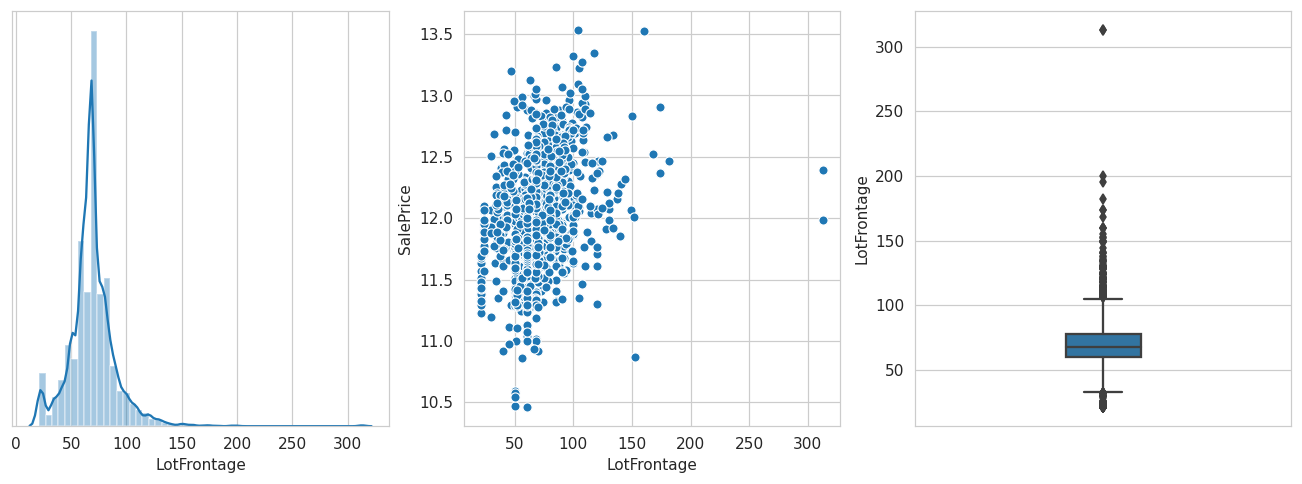

In [35]:
plot_numeric_features("LotFrontage").show()

2 Outliers present at `LotFrontage > 300`

In [36]:
drop_index = all_data['LotFrontage'][all_data['LotFrontage'] > 300].index

Skewness Coefficient of LotFrontage is 12.83


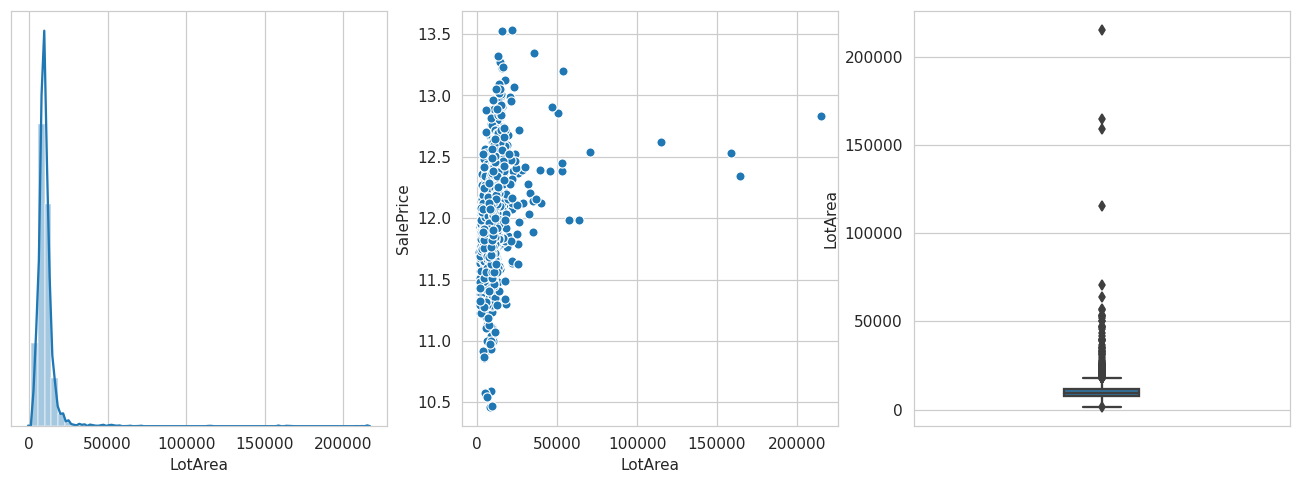

In [37]:
plot_numeric_features("LotArea").show()

4 Outliers present at `LotArea > 100000`

In [38]:
drop_index = np.append(drop_index, all_data['LotArea'][all_data['LotArea'] > 100000].index)

Skewness Coefficient of LotFrontage is 1.43


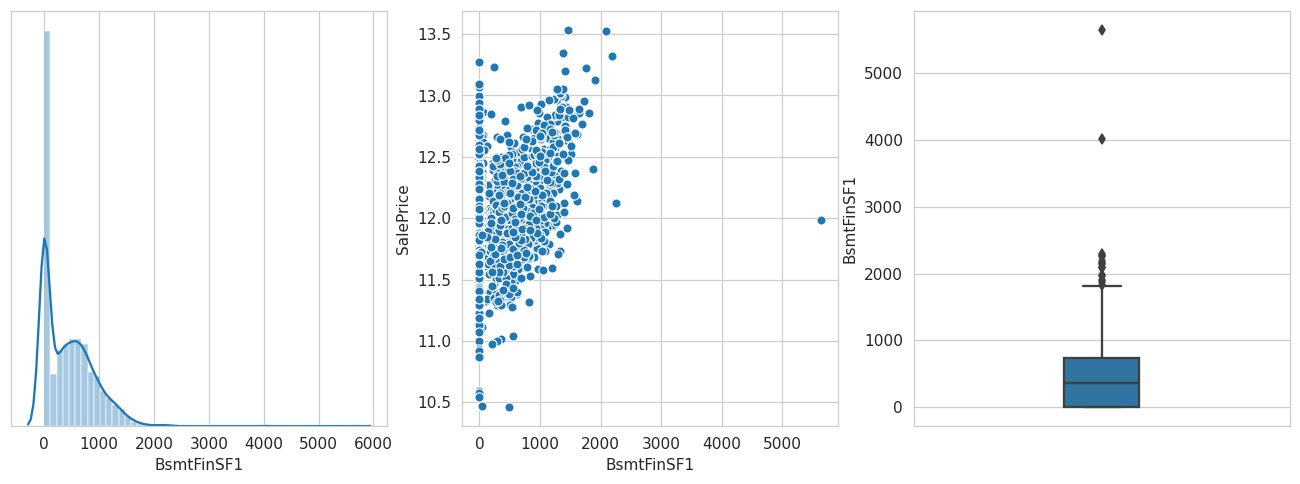

In [39]:
plot_numeric_features("BsmtFinSF1").show()

1 outlier present at `BsmtFinSF1 > 5000`

In [40]:
drop_index = np.append(drop_index, all_data['BsmtFinSF1'][all_data['BsmtFinSF1'] > 5000].index)

Skewness Coefficient of LotFrontage is 1.16


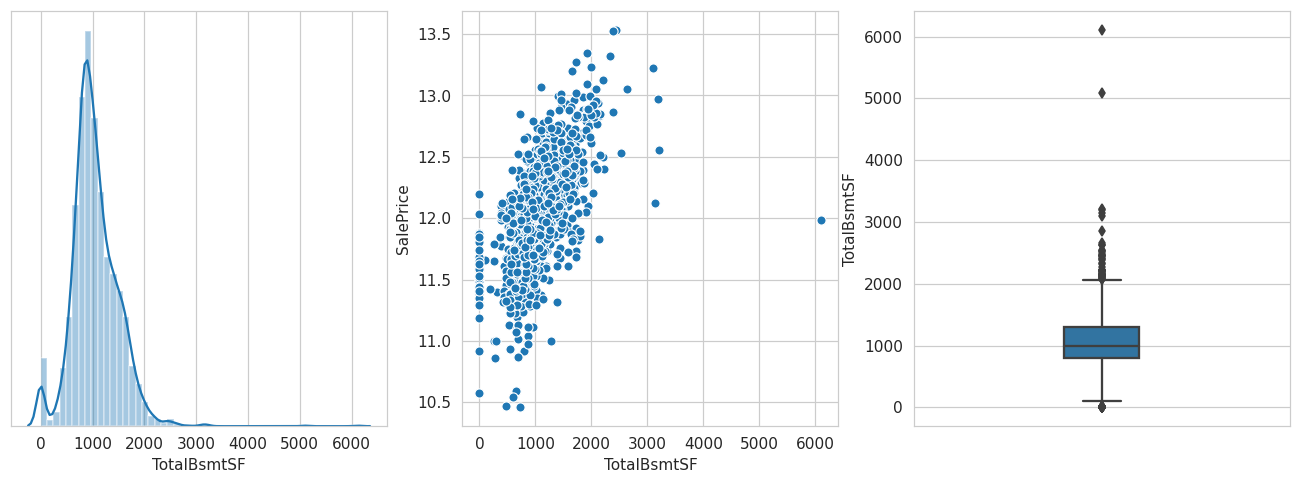

In [41]:
plot_numeric_features("TotalBsmtSF").show()

1 outlier present at `TotalBsmtSF > 6000`

In [42]:
drop_index = np.append(drop_index, all_data['TotalBsmtSF'][all_data['TotalBsmtSF'] > 6000].index)

Skewness Coefficient of LotFrontage is 1.47


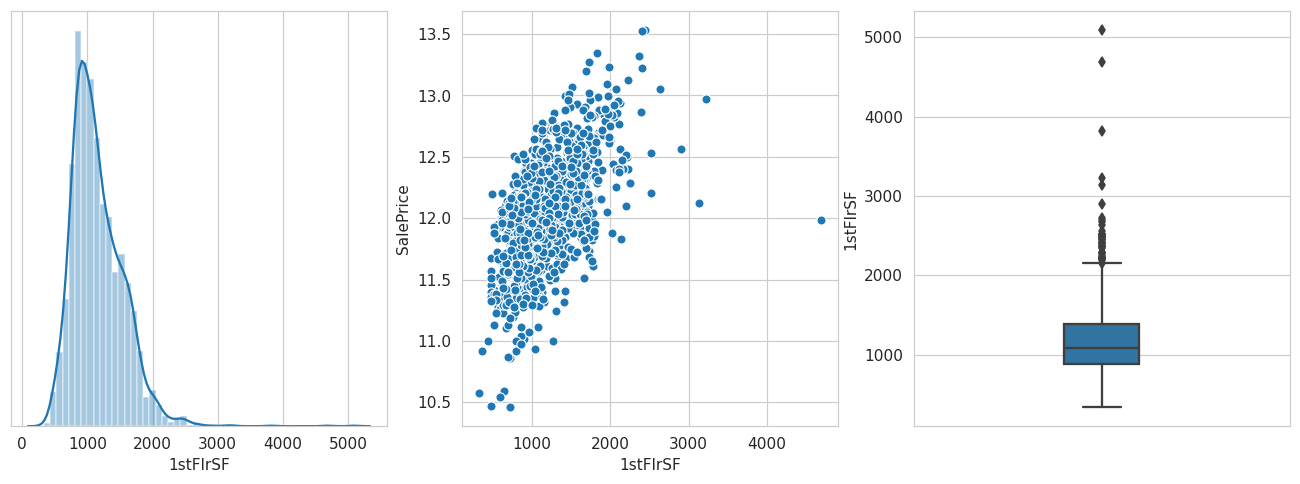

In [43]:
plot_numeric_features("1stFlrSF").show()

1 outlier present at `1stFlrSF > 4000`

In [44]:
drop_index = np.append(drop_index, all_data['1stFlrSF'][all_data['1stFlrSF'] > 4000].index)

Skewness Coefficient of LotFrontage is 1.27


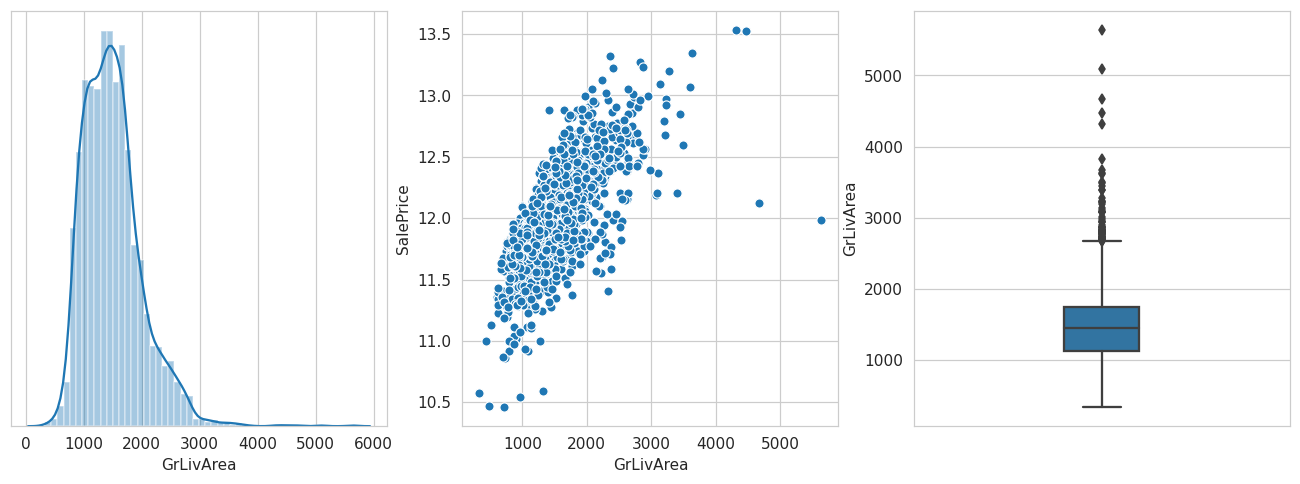

In [45]:
plot_numeric_features("GrLivArea").show()

2 outliers are present at `GrLivArea` greater than `4000` and `SalePrice` below `12.5`

In [46]:
drop_index = np.append(drop_index, all_data['GrLivArea'][
    (all_data['GrLivArea'] > 4000) & (all_data['SalePrice'] < 12.5)
].index)

In [47]:
## Making sure we only remove data from the train set
drop_index = drop_index[drop_index < ntrain]

all_data = all_data.drop(drop_index).reset_index(drop=True)

## Length of indexes dropped
dropped_count = len(drop_index)

## Modify our ntrain variable
ntrain -= dropped_count

**Note:** A total of 11 instances have been dropped. The training samples have reduced from `1460` to `1449`.

**Re-Analyzing the scatter plots after outlier removal**

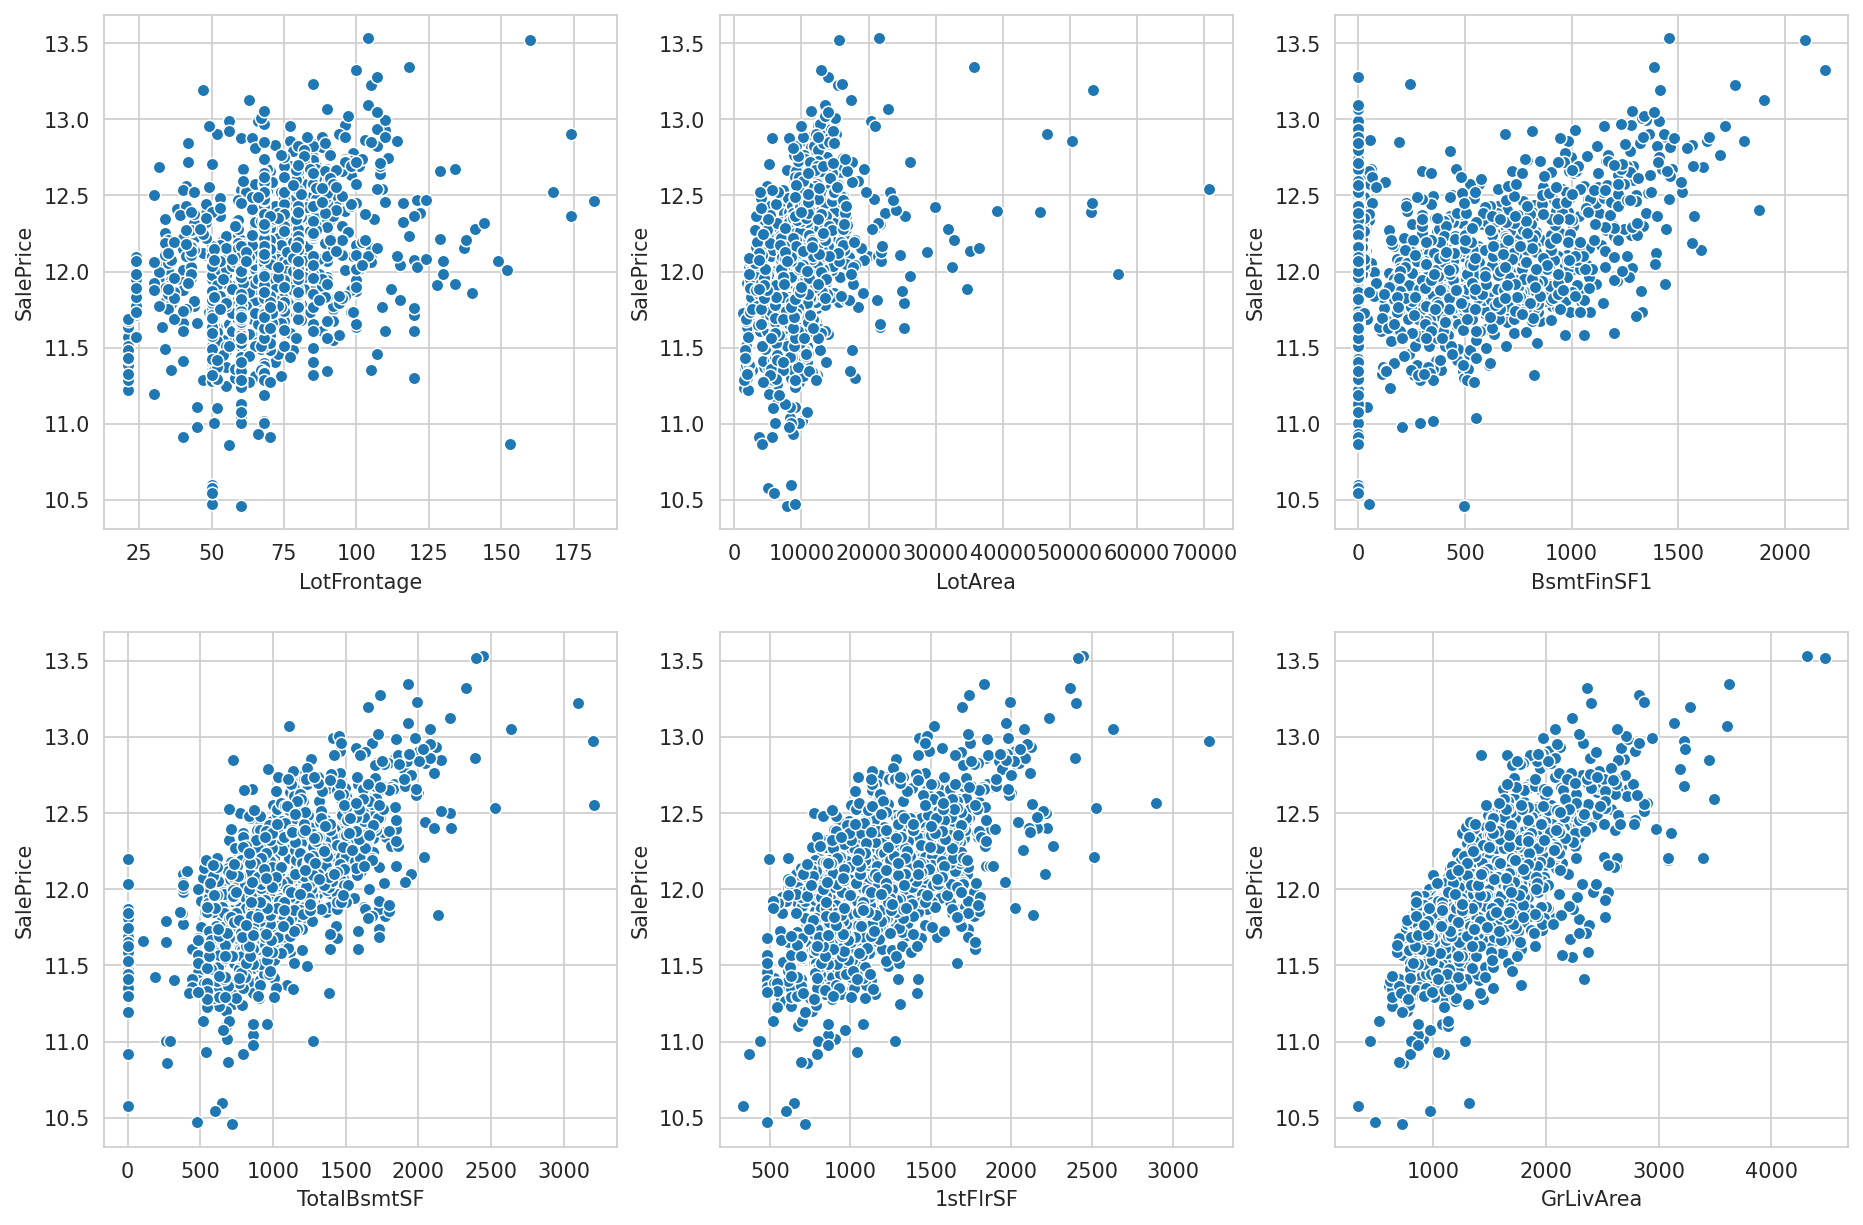

In [48]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10), dpi=150)

def create_scatter_plot(feature, axis):
    sns.scatterplot(all_data[feature], all_data["SalePrice"], ax=axis)
    
create_scatter_plot('LotFrontage', ax1)
create_scatter_plot('LotArea', ax2)
create_scatter_plot('BsmtFinSF1', ax3)
create_scatter_plot('TotalBsmtSF', ax4)
create_scatter_plot('1stFlrSF', ax5)
create_scatter_plot('GrLivArea', ax6)

plt.show()

**Log Transforming** all the **Highly Skewed Features**.

In [49]:
## Get all the numeric features in out dataset
numeric_features = all_data.skew().index

## Getting all the skewed features (skew > 0.5 or skew < -0.5)
skewed_features = all_data[numeric_features].skew()[np.abs(all_data[numeric_features].skew()) > 0.5].index

## Performing log(1+x) transformation
all_data[skewed_features] = np.log1p(all_data[skewed_features])

In [50]:
## Get all the categorical columns
cat_cols = all_data.select_dtypes("object").columns

## One-Hot Encoding all the categorical variables but dropping one of the features among them.
drop_categ = []
for i in cat_cols:
    drop_categ += [ i+'_'+str(all_data[i].unique()[-1]) ]

## Create dummy variables (One-Hot Encoding)
all_data = pd.get_dummies(all_data, columns=cat_cols) 

## Drop the last column generated from each categorical feature
all_data.drop(drop_categ, axis=1, inplace=True)

In [51]:
X_train =  all_data[:-ntest].drop(['SalePrice'], axis=1)
y_train =  all_data[:-ntest]['SalePrice']
X_test  =  all_data[-ntest:].drop(['SalePrice'], axis=1)

## Remove SalePrice from numeric_features to avoid scaling it
numeric_features = numeric_features.drop('SalePrice')

## Scaling all the numeric features using Robust Scaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features]  = scaler.transform(X_test[numeric_features])

# Feature Extraction

We will be using **XGBRegressor** to find the importance of each feature.

In [52]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

xgb.fit(X_train, y_train)
df_imp = pd.DataFrame(xgb.feature_importances_ , columns = ['Importance'], index=X_train.columns)
df_imp = df_imp.sort_values(['Importance'], ascending = False)

df_imp.head()

[11:18:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Importance
ExterQual,0.296839
GarageFinish,0.131651
GarageCars,0.074324
FireplaceQu,0.070875
KitchenQual,0.059247


Find all the `highly important features` using **XGBRegressor**

In [53]:
## Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

## Function to calculate negative RMSE
def nrmse(y_true, y_pred):
    return -1.0*rmse(y_true, y_pred)

from sklearn.metrics import make_scorer
neg_rmse = make_scorer(nrmse)

from xgboost import XGBRegressor
estimator = XGBRegressor()

from sklearn.feature_selection import RFECV
estimates = RFECV(estimator, cv = 3, n_jobs = -1, scoring = neg_rmse)
estimates = estimates.fit(X_train, y_train)

print(f"No. of highly important features: {estimates.n_features_}")

## List of important features
imp_features = X_train.columns.values[estimates.support_]

X_train =  X_train[imp_features]
X_test  =  X_test[imp_features]

[11:20:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:20:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:20:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:20:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:20:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:20:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:20:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

# Modeling and Evaluation

Since we have already selected all the important features, it is wise to use the `Kernel Ridge` rather than `ElasticNet` or `Lasso`.

In [54]:
from sklearn.kernel_ridge import KernelRidge
ridge = KernelRidge()

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
parameters = {
    'alpha': uniform(0.05, 1.0), 'kernel': ['polynomial'], 'degree': [2], 'coef0': uniform(0.5, 3.5)
}

random_search = RandomizedSearchCV(
    estimator = ridge, param_distributions = parameters, n_iter = 1000, 
    cv = 3, scoring = neg_rmse, n_jobs = -1, random_state=0
)

random_search = random_search.fit(X_train, y_train)

model = random_search.best_estimator_

print(f"Training RMSE: {round(rmse(y_train, model.predict(X_train)), 3)}")

Training RMSE: 0.095


# Prediction

In [55]:
## Inverse Transforming log transformed SalePrice (y_pred)
y_pred = np.exp(model.predict(X_test))

## Final DataFrame consisting of the SalePrice
output = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': y_pred})

#output.to_csv('prediction.csv', index=False)

<center><h1>PLEASE UPVOTE</h1></center>

<center><h3>Don't forget to UPVOTE if you find this Notebook useful. It will keep me motivated.</h3></center>

<center><h1>--- END ---</h1></center>

Subscribe to my Tech Blog: [Viking's Tech Blog](https://viking-pathak.blogspot.com)

Follow my Data Science Page on instagram: [@gameofdata](https://www.instagram.com/gameofdata)

Connect with me on LinkedIN: [Amit Pathak](https://www.linkedin.com/in/viking-pathak)